# Hysteresis simulations

In this tutorial, we summarise some of the convenience methods offered by Ubermag that can be used for simulating hysteresis. Let us first define a simple system object. For details on how to define simulations, please refer to other tutorials.

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

region = df.Region(p1=(-50e-9, -50e-9, -50e-9), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='hysteresis')
system.energy = mm.Exchange(A=1e-12) + mm.UniaxialAnisotropy(K=4e5, u=(0, 0, 1)) + mm.DMI(D=1e-3, crystalclass='T')# + mm.Demag()

def Ms_fun(point):
    x, y, z = point
    if x**2 + y**2 + z**2 <= 50e-9**2:
        return 1e6
    else:
        return 0
    
system.m = df.Field(mesh, dim=3, value=(0, 0, -1), norm=Ms_fun)

Now that we have `system` object we can simulate hysteresis using `HysteresisDriver`. Like all other drivers, `HysteresisDriver` has `drive` method. As input arhuments it takes `system` object (as usual) and:

- `Hmin` - the starting value of magnetic field
- `Hmin` - the end value of magnetic field
- `n` - the number of points between `Hmin` and `Hmax`

For instance, let us say we want to simulate hysteresis between $-1\,\text{T}$ and $1\,\text{T}$ applied along the $z$-direction in steps of $0.2\,\text{T}$. Accordingly, `Hmin` and `Hmax` are: 

In [2]:
Hmin = (0, 0, -1/mm.consts.mu0)
Hmax = (0, 0, 1/mm.consts.mu0)

The number of steps `n` should be 21, so that the values of magnetic field are: $-1\,\text{T}$, $-0.9\,\text{T}$, $-0.8\,\text{T}$, ..., $0.9\,\text{T}$, $1\,\text{T}$, $0.9\,\text{T}$, $0.8\,\text{T}$, ..., $-0.9\,\text{T}$, $-1\,\text{T}$.

In [3]:
n = 21

We can now create `HysteresisDriver` and drive the system.

In [4]:
hd = mc.HysteresisDriver()
hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)

Running OOMMF (ExeOOMMFRunner) [2021/01/04 11:30]... (2.5 s)


After the simulation is complete, we can have a look at the last magnetisation step:

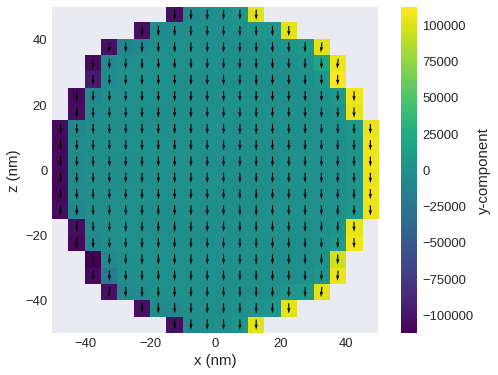

In [5]:
system.m.plane('y').mpl()

Similarly, table can be viewed:

In [6]:
system.table.data.head()

,max_mxHxm,E,delta_E,bracket_count,line_min_count,conjugate_cycle_count,cycle_count,cycle_sub_count,energy_calc_count,E_exchange,...,B,Bx,By,Bz,iteration,stage_iteration,stage,mx,my,mz
0,0.081205,-5.296243e-16,-3.944305e-31,9.0,9.0,1.0,8.0,7.0,19.0,1.178506e-19,...,1000.0,0.0,0.0,-1000.0,18.0,18.0,0.0,3.445056e-21,-7.234617e-20,-0.998400
1,0.079357,-4.769135e-16,-6.902533e-31,16.0,15.0,2.0,15.0,6.0,33.0,1.301416e-19,...,900.0,0.0,0.0,-900.0,32.0,13.0,1.0,3.100550e-19,1.722528e-20,-0.998216
2,0.056168,-4.242133e-16,1.972152e-31,23.0,22.0,3.0,22.0,6.0,48.0,1.445097e-19,...,800.0,0.0,0.0,-800.0,47.0,14.0,2.0,-2.583792e-19,2.756045e-20,-0.997999
3,0.086405,-3.715256e-16,-4.437343e-31,31.0,29.0,4.0,29.0,6.0,64.0,1.614662e-19,...,700.0,0.0,0.0,-700.0,62.0,14.0,3.0,-4.134067e-20,6.201100e-20,-0.997739
4,0.053102,-3.188531e-16,-2.465190e-31,40.0,36.0,5.0,37.0,7.0,81.0,1.816966e-19,...,600.0,0.0,0.0,-600.0,78.0,15.0,4.0,-1.378022e-20,2.756045e-20,-0.997422


From the table, we can see at what external magnetic field the system was relaxed:

In [7]:
system.table.data['B']

0     1000.0
1      900.0
2      800.0
3      700.0
4      600.0
5      500.0
6      400.0
7      300.0
8      200.0
9      100.0
10       0.0
11     100.0
12     200.0
13     300.0
14     400.0
15     500.0
16     600.0
17     700.0
18     800.0
19     900.0
20    1000.0
21     900.0
22     800.0
23     700.0
24     600.0
25     500.0
26     400.0
27     300.0
28     200.0
29     100.0
30       0.0
31     100.0
32     200.0
33     300.0
34     400.0
35     500.0
36     600.0
37     700.0
38     800.0
39     900.0
40    1000.0
Name: B, dtype: float64

The units of $B$ are:

In [8]:
system.table.units['B']

'mT'

## Plotting hysteresis loop

Using `Table` object, we can plot different values as a function of external magnetic field. For that, as usual, we use `mpl` method. We have to specify to that method what do we want to have on the $y$-axis.

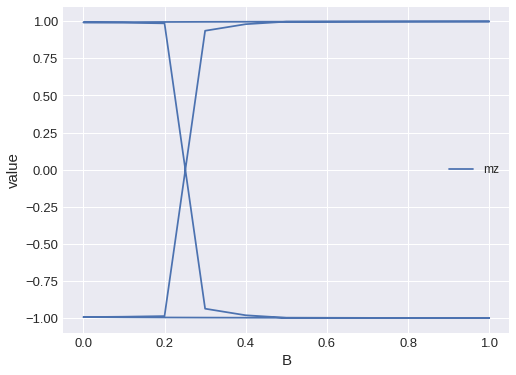

In [9]:
system.table.mpl(y=['mz'])

This does not look like a hysteresis loop as we expected. The reason is that on the horizontal axis we have the magnitude `B` by default, which is always positive. We can change that by passing `Bz` for `x`:

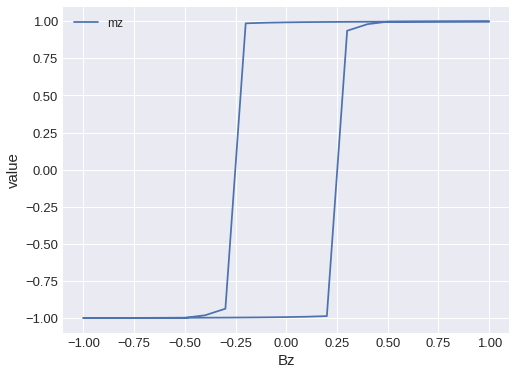

In [10]:
system.table.mpl(x='Bz', y=['mz'])

`Table.mpl` is based on `matplotlib.pyplot.plot`, so any keyword argument accepted by it can be passed:

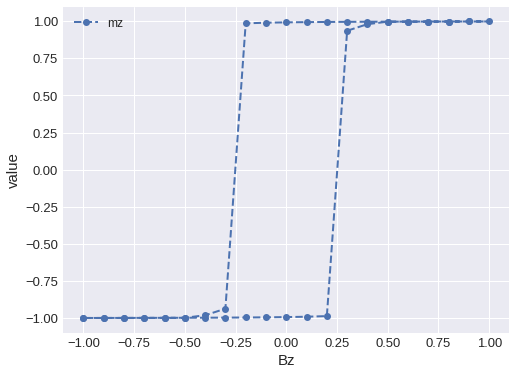

In [11]:
system.table.mpl(x='Bz', y=['mz'], marker='o', linewidth=2, linestyle='dashed')

## `micromagneticdata` analysis

We can also analyse magnetisation fields at different values of external magnetic field as well as building interactive plots using `micromagneticdata` package.

In [12]:
import micromagneticdata as md

We can create a data object by passing system's name.

In [13]:
data = md.Data(name=system.name)

Now, we can have a look at all drives we did so far:

In [14]:
data.info

,drive_number,date,time,driver,Hmin,Hmax,n
0,0,2021-01-04,11:30:56,HysteresisDriver,"[0, 0, -795774.7154594767]","[0, 0, 795774.7154594767]",21


There is only one drive with index `0`. We can get if by indexing the data object:

In [15]:
drive = data[0]

The number of steps saved is:

In [16]:
drive.n

41

We can get an individual step by passing a value between 0 and 40 as an index:

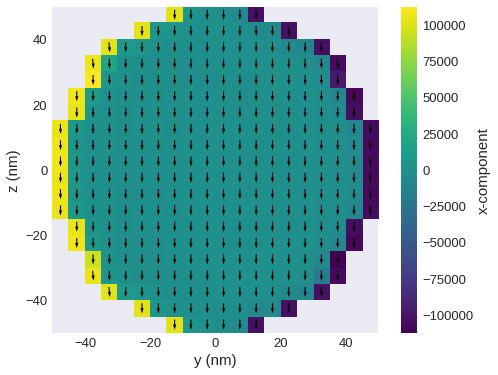

In [17]:
drive[0].plane('x').mpl()

We can also interactively plot all individual steps by using widgets. For more details on creating interactive plots, please refer to other tutorials.

In [18]:
@df.interact(step=drive.slider(continuous_update=False))
def my_plot(step):
    drive[step].plane('x').mpl()

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=40), Output()), _dom…